In [101]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from dataclasses import dataclass, field
from typing import Dict, List
from gravpop import *
from truncnormkde import *
from matplotlib.patches import Ellipse


import numpyro.distributions as dist
prior = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,1), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,1), 
    'rho' : dist.Uniform(-1,1)
}

class JefferysPrior:
    def __init__(self, hyper_var_names, eta=1):
        self.hyper_var_names = hyper_var_names
        self.eta = eta
        
    def logpdf(self, x):
        rho = x.get(self.hyper_var_names[4],0)
        det = 1-rho**2
        return (self.eta-1)*jnp.log(det)

latex_symbols = {
    'mu_x' : r"$\mu_x$", 
    'sigma_x' : r"$\sigma_x$", 
    'mu_y' : r"$\mu_y$", 
    'sigma_y': r"$\sigma_y$", 
    'rho' : r"$\rho$"
}

@dataclass
class TruncatedGaussianTests:
    parameters : Dict
    sigma_likelihood : float = 0.5
    N_events : int = 500
    oversample_ratio : int = 10
    a : np.array = field(default_factory=lambda : np.array([0,0]))
    b : np.array = field(default_factory=lambda : np.array([1,1]))
    
    def unpack_sigmas(self):
        return self.parameters['sigma_x'], self.parameters['sigma_y'], self.parameters.get('rho', 0.0)
    
    def unpack_mus(self):
        return self.parameters['mu_x'], self.parameters['mu_y']
    
    def generate(self, N):
        self.N = N
        a = self.a; b = self.b;
        mu_1, mu_2 = self.unpack_mus()
        sigma_1, sigma_2, rho = self.unpack_sigmas()
        Sigma = np.array([[sigma_1**2, rho*sigma_1*sigma_2],[rho*sigma_1*sigma_2, sigma_2**2]])
        L = np.linalg.cholesky(Sigma)
        Z = np.random.randn(2,self.N_events*self.oversample_ratio)
        X = (L @ Z) + jnp.array([mu_1, mu_2])[:,None]
        
        x_in_range = (X[0,:] > a[0]) & (X[0,:] < b[0])
        y_in_range = (X[1,:] > a[1]) & (X[1,:] < b[1])

        X = X[:, x_in_range & y_in_range]

        X = X[:, 0:self.N_events]
        
        self.X = X
        
    def plot_intrinsic_parameters(self, alpha=0.01):
        import matplotlib.pyplot as plt

        fig,ax = plt.subplots(1)
        
        for i in range(self.X.shape[1]):
            cov_matrix = np.diag([self.sigma_likelihood**2, self.sigma_likelihood**2])
            eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
            angle = np.degrees(np.arctan2(eig_vectors[1, 0], eig_vectors[0, 0]))
            width = np.sqrt(eig_values[0]) * 2 * 1.645  # 90% CI
            height = np.sqrt(eig_values[1]) * 2 * 1.645  # 90% CI

            ellipse = Ellipse(xy=(self.X[0, i], self.X[1, i]),
                              width=width,
                              height=height,
                              angle=angle,
                              edgecolor=None,
                              lw=2,
                              facecolor='b',
                              #alpha=1/(self.N_events*((7*self.sigma_likelihood)**2)))
                              alpha=alpha)
            ax.add_patch(ellipse)
            
        ax.scatter(self.X[0,:], self.X[1,:], color="k")
            
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_xlim((self.a[0], self.b[0]))
        ax.set_ylim((self.a[1], self.b[1]))
        #plt.legend()
        plt.title(f"{self.N_events} events")
        plt.show()
        
    def create_data(self):
        event_data =  {'x_mu_kernel' : self.X[0,:][None].T + np.random.randn(*(self.X[0,:][None].T).shape)*self.sigma_likelihood,
                       'y_mu_kernel' : self.X[1,:][None].T + np.random.randn(*(self.X[1,:][None].T).shape)*self.sigma_likelihood,
                       'x_sigma_kernel' : self.sigma_likelihood*np.ones((self.N_events, 1)),
                       'y_sigma_kernel' : self.sigma_likelihood*np.ones((self.N_events, 1)),
                       'weights' : np.ones((self.N_events, 1))}
        
        self.event_data = event_data
        
        return event_data
    
    def infer(self, model, num_samples=1000, prior=prior, latex_symbols={}):
        self.HL = HybridPopulationLikelihood(sampled_models=[], analytic_models=[model],
                                        event_data = self.event_data, selection_data=None)
        
        the_sampler = Sampler(priors = {k:v for k,v in prior.items() if k in self.parameters.keys()},
                      constraints=[JefferysPrior(['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho'])],
                      latex_symbols={k: latex_symbols.get(k, k) for k in self.parameters.keys()},
                      likelihood=self.HL,
                      num_samples=num_samples)
        
        the_sampler.sample()
        self.sampler = the_sampler
        
        the_sampler.corner(truth=np.array([self.parameters[key] for key in the_sampler.samples.columns]));
        
    def compare_posterior_predictive(self):
        import matplotlib.pyplot as plt
        data_grid = Grid([Grid1D('x', 0, 1, 100), Grid1D('y', 0, 1, 100)]).data

        Z_init = self.HL.models[0].evaluate(data_grid, self.parameters)
        chuncked_func = chunked_vmap(lambda x: self.HL.models[0].evaluate(data_grid, x), 
                                     in_axes=({k:0 for k in self.parameters.keys()},), 
                                     chunk=100)
        Z = chuncked_func({col:self.sampler.samples[col].values for col in self.sampler.samples.columns})

        fig, axes = plt.subplots(ncols=2, figsize=(10,5))
        axes[0].contourf(data_grid['x'], data_grid['y'], jnp.median(Z,axis=0))
        axes[0].set_title("Median Posterior Predictive")
        axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)
        axes[1].set_title("Injected Distribution")
        plt.show()
        
    def quantile_posterior_predictive(self, quantiles=[0.25, 0.5, 0.75]):
        import matplotlib.pyplot as plt
        data_grid = Grid([Grid1D('x', 0, 1, 100), Grid1D('y', 0, 1, 100)]).data

        Z_init = self.HL.models[0].evaluate(data_grid, self.parameters)
        chuncked_func = chunked_vmap(lambda x: self.HL.models[0].evaluate(data_grid, x), 
                                     in_axes=({k:0 for k in self.parameters.keys()},), 
                                     chunk=100)
        Z = chuncked_func({col:self.sampler.samples[col].values for col in self.sampler.samples.columns})
        
        mu_1, mu_2 = self.unpack_mus()

        fig, axes = plt.subplots(ncols=len(quantiles), figsize=(10,5))
        for i in range(len(quantiles)):
            contour_plot = axes[i].contourf(data_grid['x'], data_grid['y'], jnp.quantile(Z, quantiles[i], axis=0))
            axes[i].set_title(f"{np.round(quantiles[i]*100, 2)} Posterior Predictive")
            plt.colorbar(contour_plot, ax=axes[i])
            axes[i].scatter([mu_1],[mu_2], color='r', marker='x')
        plt.show()
        
    def ppd(self):
        #posts = {col:self.sampler.samples[col].values for col in self.sampler.samples.columns};
        df_samps = self.HL.models[0].sample(self.sampler.samples, oversample=10)
        return BoundedKDEPlot(df_samps).plot(a=self.a, b=self.b)


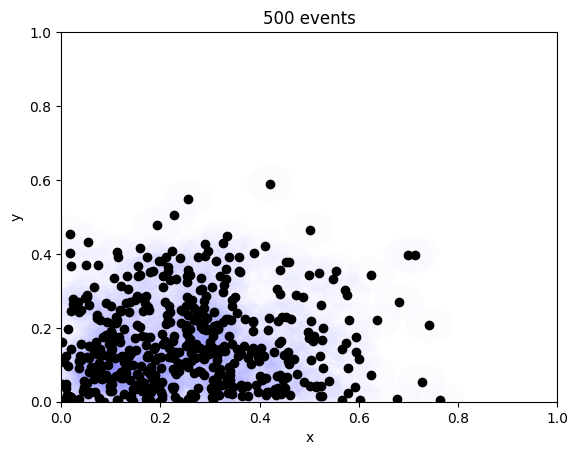

No selection function provided


sample: 100%|███████████████████████████████████████████| 2000/2000 [00:11<00:00, 168.66it/s, 7 steps of size 2.79e-01. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.20      0.02      0.20      0.17      0.22    325.55      1.00
      mu_y      0.03      0.02      0.03      0.00      0.06    210.82      1.00
   sigma_x      0.20      0.01      0.20      0.18      0.22    311.83      1.01
   sigma_y      0.19      0.01      0.19      0.17      0.20    202.40      1.00

Number of divergences: 0


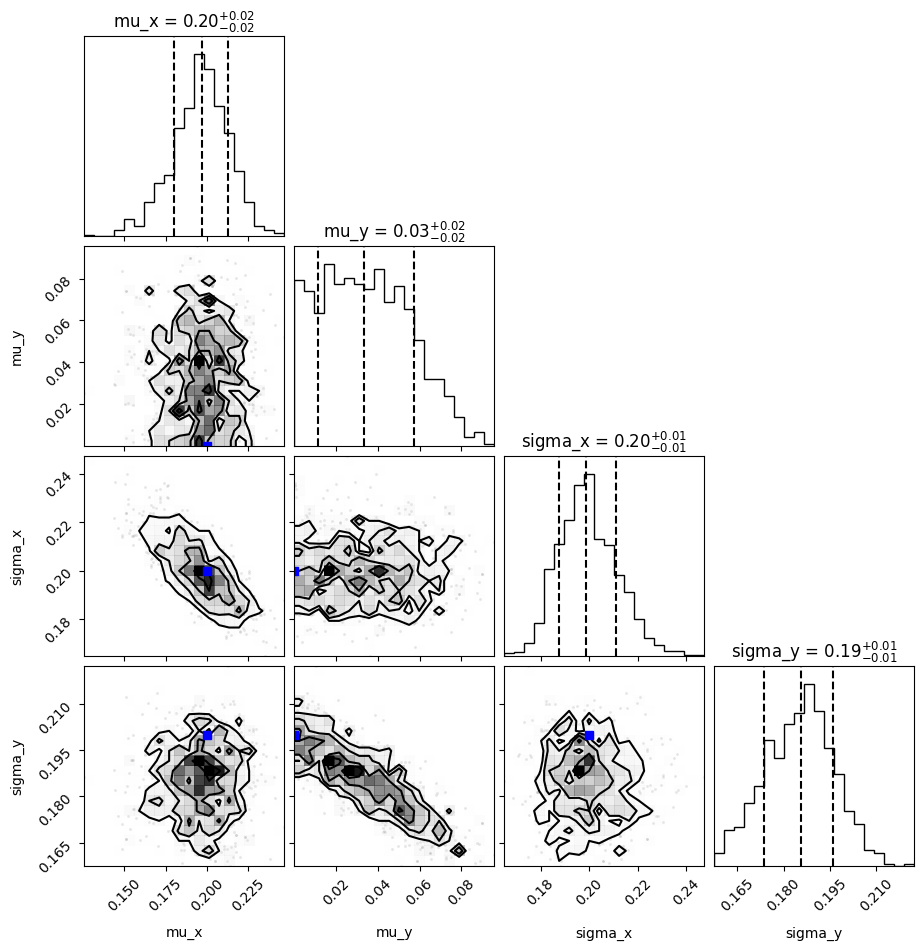

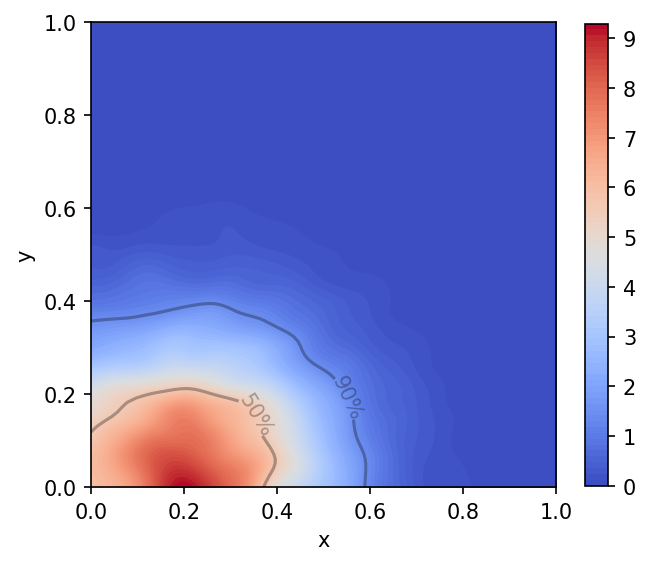

In [82]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.2, 'sigma_x': 0.2, 'mu_y': 0.0, 'sigma_y':0.2},
                       sigma_likelihood=0.03, N_events=500)


TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG1D = TruncatedGaussian1DIndependentAnalytic(a=0, b=1, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters();

TGT.infer(TG1D)

#TGT.compare_posterior_predictive()

#TGT.quantile_posterior_predictive()
TGT.ppd();

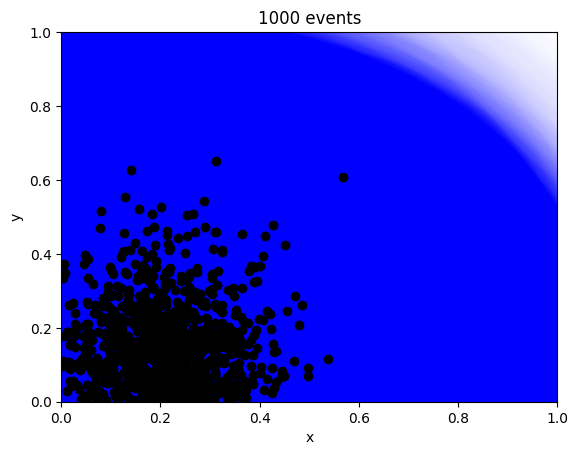

No selection function provided


sample: 100%|███████████████████████████████████████████| 2000/2000 [02:42<00:00, 12.30it/s, 35 steps of size 8.10e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.17      0.08      0.20      0.02      0.27    227.40      1.00
      mu_y      0.11      0.06      0.11      0.01      0.19    337.78      1.00
       rho     -0.37      0.55     -0.50     -1.00      0.42    306.61      1.00
   sigma_x      0.25      0.20      0.22      0.00      0.52    137.89      1.00
   sigma_y      0.21      0.14      0.18      0.01      0.39    136.77      1.00

Number of divergences: 1


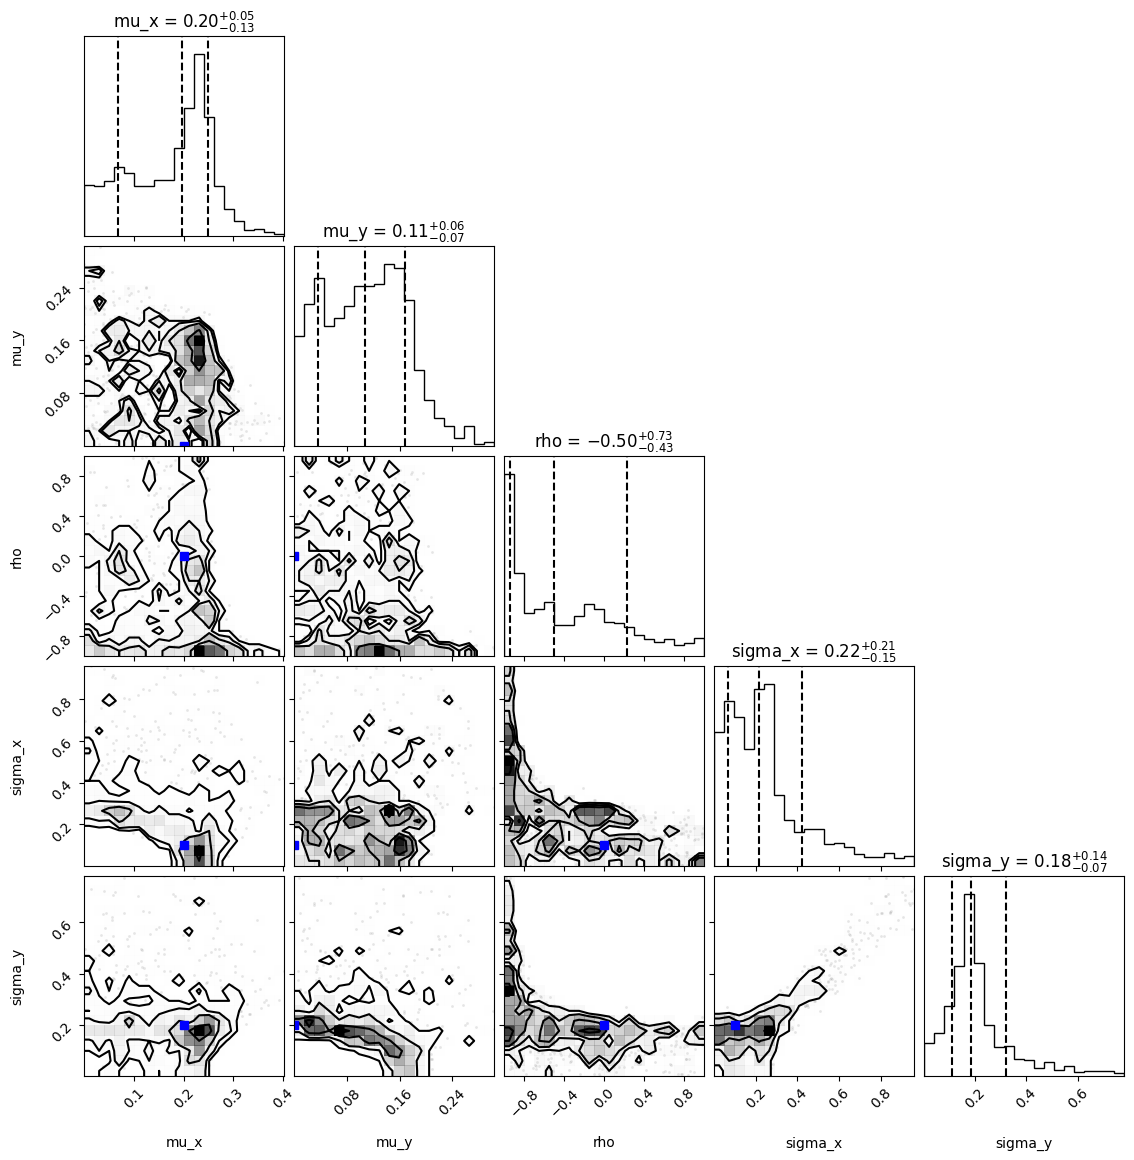

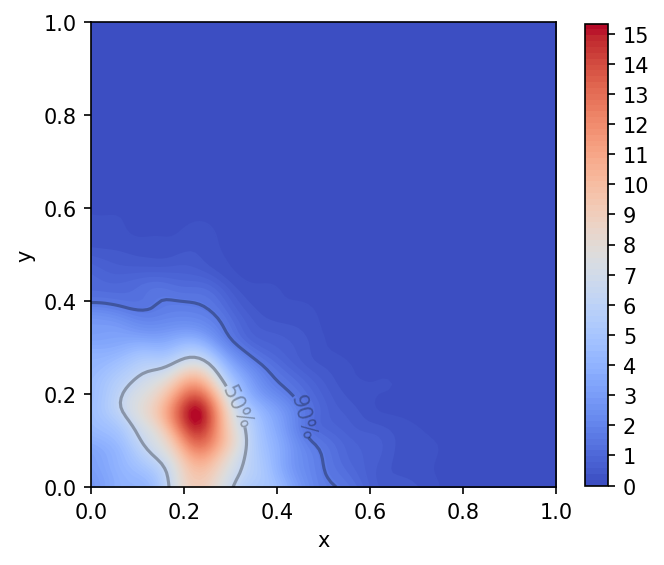

In [105]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.2, 'sigma_x': 0.1, 'mu_y': 0.0, 'sigma_y':0.2, 'rho': 0.0},
                       sigma_likelihood=0.5, N_events=1000)


TGT.generate(1000)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D)

#TGT.compare_posterior_predictive()

#TGT.quantile_posterior_predictive()
TGT.ppd();

In [96]:
juliacall.Main.get_correlation(0.2, 0.1, 0.0, 0.2, 0.0)

-0.1824301590639567

Progress: 100%|███████████████████████��█████████████████| Time: 0:00:00


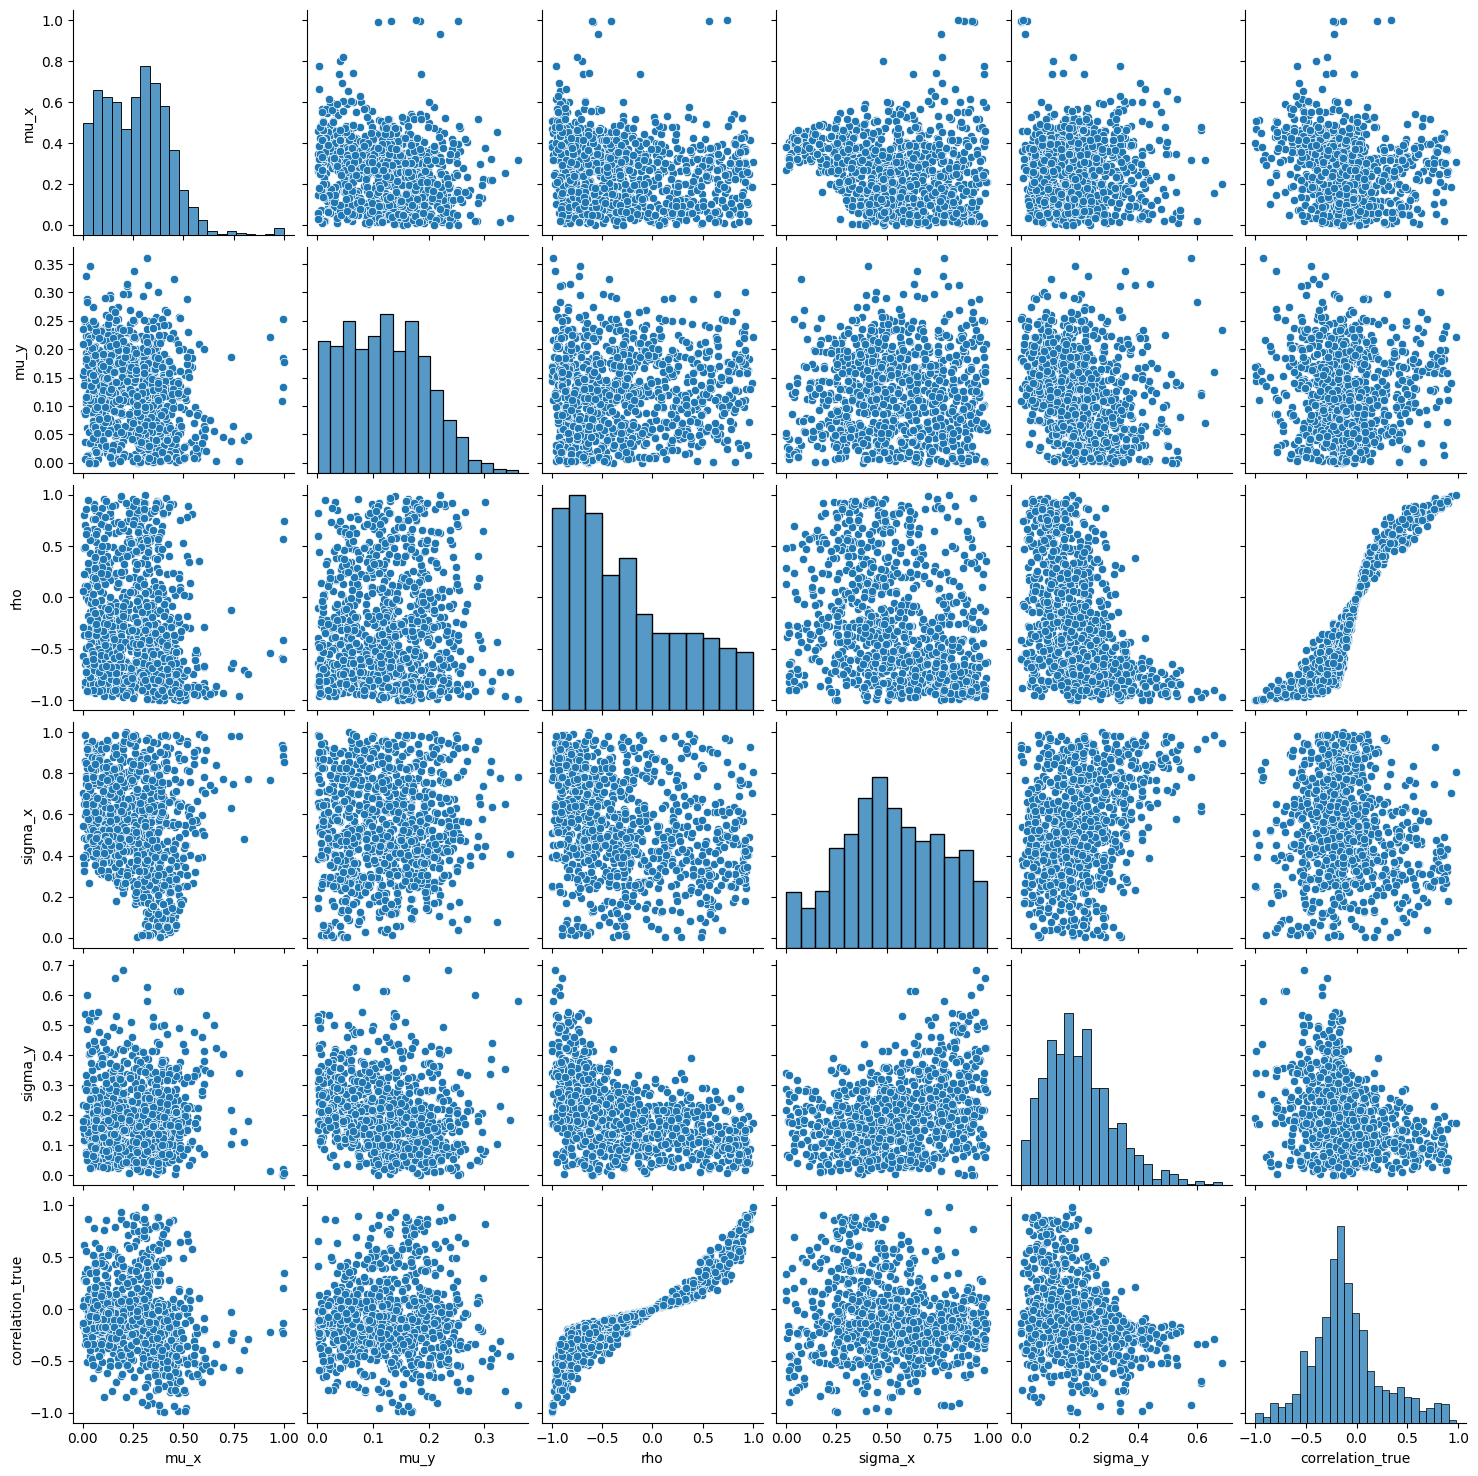

In [103]:
import juliacall


testfunc = juliacall.Main.seval("""
using Distributions
using TruncatedGaussianMixtures
using DataFrames
using ProgressMeter

make_trunc_norm(μ1, σ1, μ2, σ2, ρ; a=[0.0, 0.0], b=[1.0, 1.0]) = TruncatedMvNormal(MvNormal([μ1, μ2], [σ1^2 σ1*σ2*ρ; σ1*σ2*ρ σ2^2]), a, b);
function get_correlation(μ1, σ1, μ2, σ2, ρ; a=[0.0, 0.0], b=[1.0, 1.0])
    M1, M2 = TruncatedGaussianMixtures.moments(make_trunc_norm(μ1, σ1, μ2, σ2, ρ; a=a, b=b));
    Σ = M2 - M1 * M1';
    Σ[1,2]/sqrt(Σ[1,1]*Σ[2,2])
end

function get_true_correlations(df; cols=[:mu_chi_1_at_0, :sigma_chi_1_at_0, :mu_chi_2_at_0, :sigma_chi_2_at_0, :rho_chi_1], a=[0.0, 0.0], b=[1.0, 1.0])
    df_prior = DataFrame();
    N = nrow(df);
    for col in cols
        if occursin("rho", string(col))
            df_prior[!, col] = 2 .* rand(N) .- 1
        else
            df_prior[!, col] = rand(N);
        end
    end

    corrs = zeros(N)
    corrs_prior = zeros(N)
    @showprogress for (i,x) in enumerate(eachrow(df))
        corrs[i] = get_correlation([df[i, col] for col in cols]...; a=a, b=b)
        corrs_prior[i] = get_correlation([df[i, col] for col in cols]...; a=a,b=b)
    end
    df[!, :correlation_true] = corrs;
    df_prior[! ,:correlation_true] = corrs_prior;

    df, df_prior
end

x -> get_true_correlations(DataFrame(x); cols=[:mu_x, :sigma_x, :mu_y, :sigma_y, :rho], a=[0.0, 0.0], b=[1.0, 1.0])
""")

df, df_prior = testfunc(pd.DataFrame({col : np.array(TGT.sampler.samples[col].values, dtype='float') for col in TGT.sampler.samples}));

import seaborn as sns
sns.pairplot(pd.DataFrame({col : np.array(getattr(df, col)) for col in juliacall.Main.names(df)}))
plt.show()

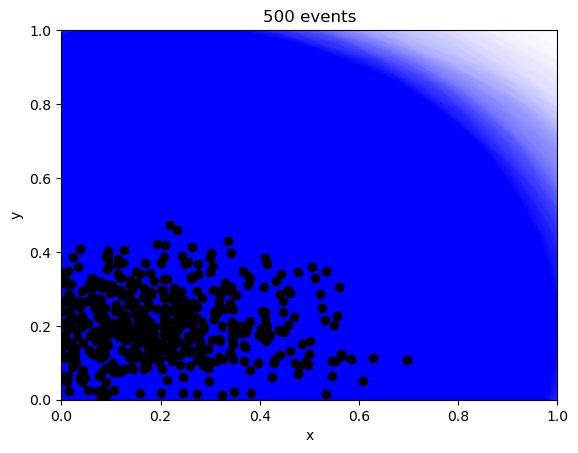

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 33.09it/s, 23 steps of size 1.23e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.12      0.08      0.11      0.00      0.22    345.79      1.00
      mu_y      0.12      0.06      0.13      0.01      0.21    287.35      1.00
       rho     -0.21      0.63     -0.25     -1.00      0.73    221.45      1.00
   sigma_x      0.39      0.48      0.24      0.00      0.78    163.81      1.00
   sigma_y      0.29      0.41      0.16      0.00      0.66    165.77      1.00

Number of divergences: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


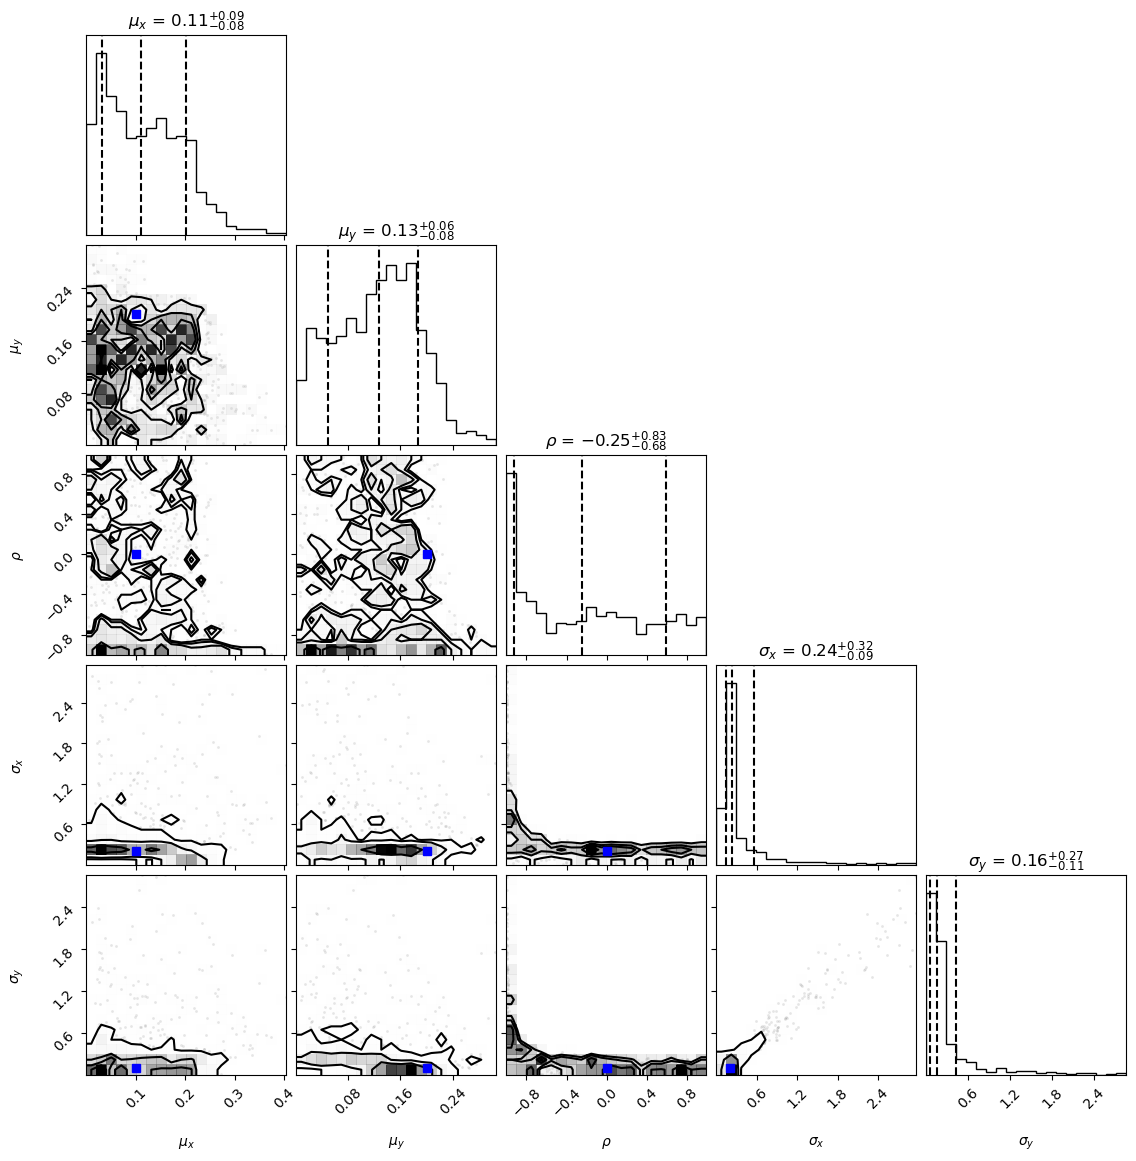

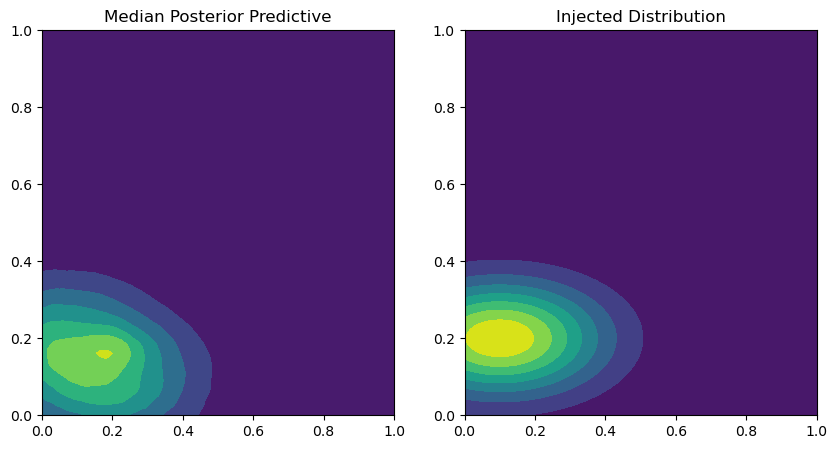

  0%|          | 0/1000 [00:00<?, ?it/s]

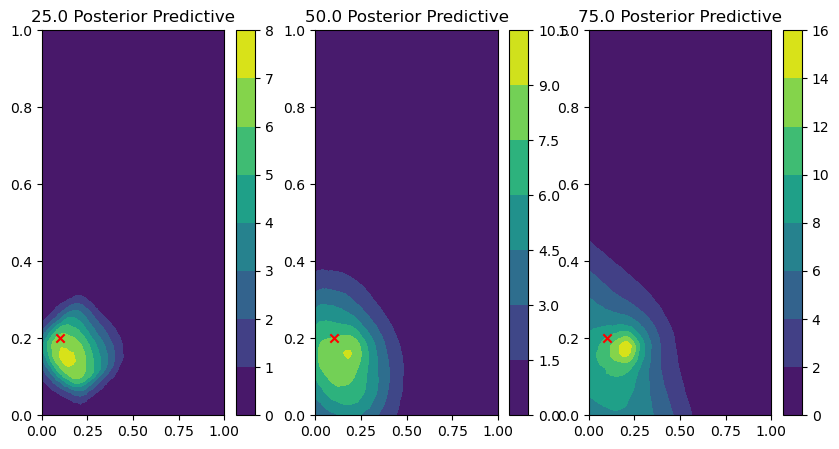

In [168]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.1, 'sigma_x': 0.2, 'mu_y': 0.2, 'sigma_y':0.1, 'rho': 0.0},
                       sigma_likelihood=0.5)


TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


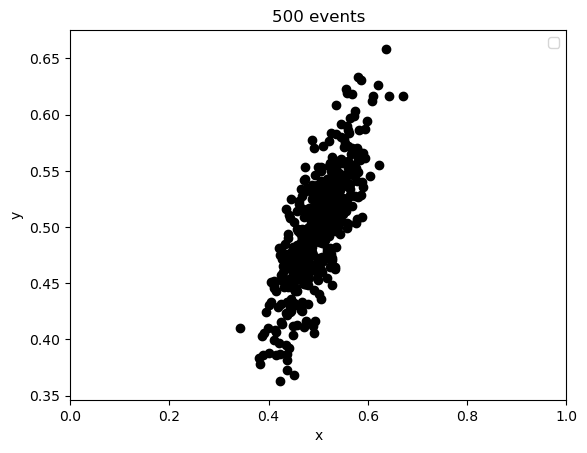

No selection function provided


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.52it/s, 7 steps of size 4.58e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.50      0.00      0.50      0.50      0.50    642.66      1.00
      mu_y      0.50      0.00      0.50      0.49      0.50    692.94      1.00
       rho      0.78      0.02      0.78      0.75      0.81    575.92      1.00
   sigma_x      0.05      0.00      0.05      0.05      0.05    549.19      1.00
   sigma_y      0.05      0.00      0.05      0.05      0.05    519.77      1.00

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/1673770611.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


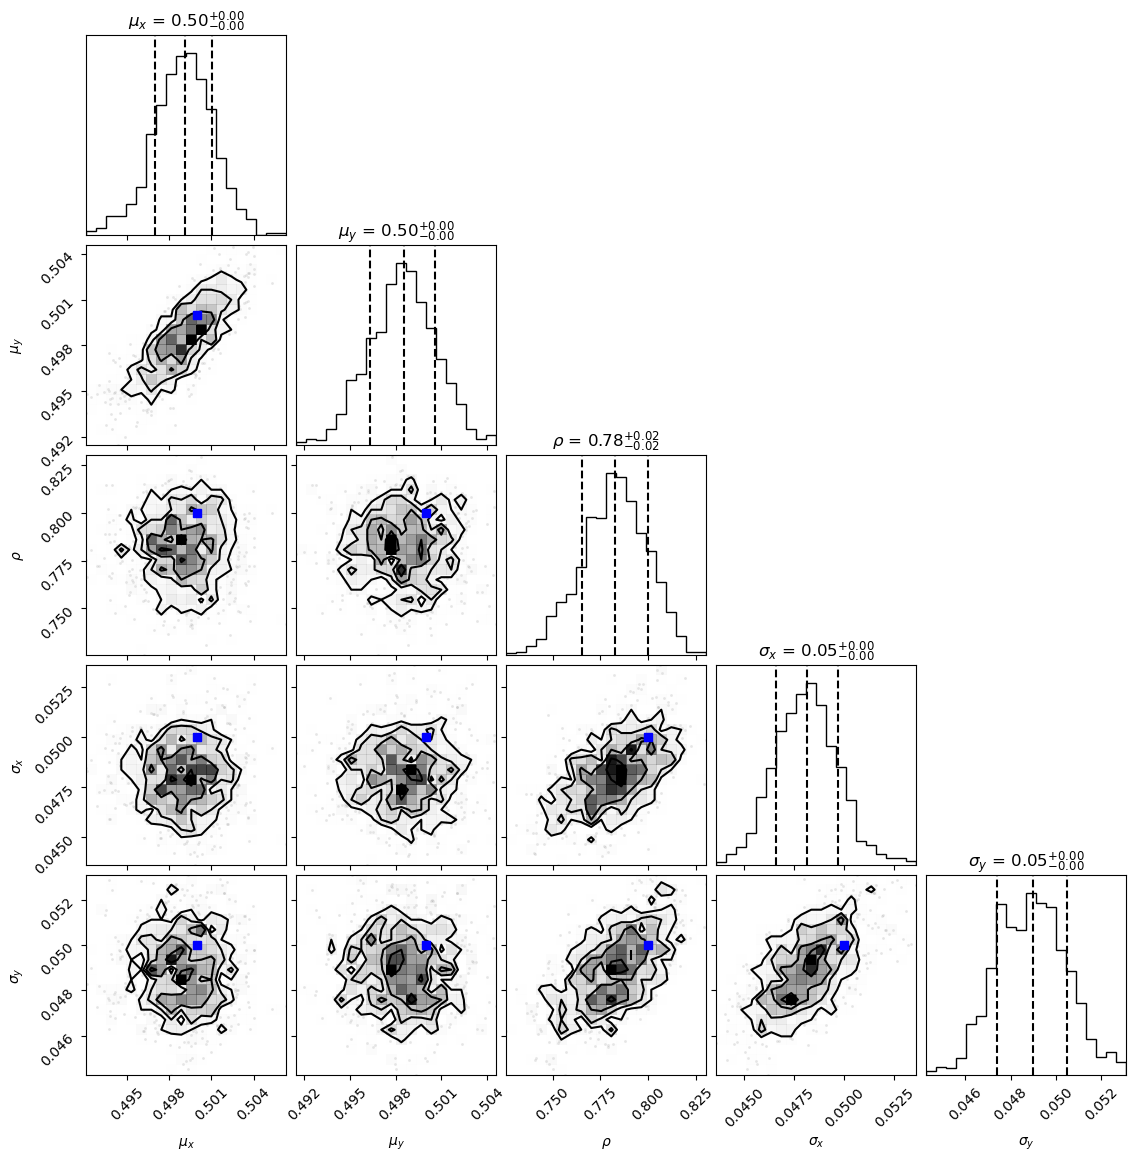

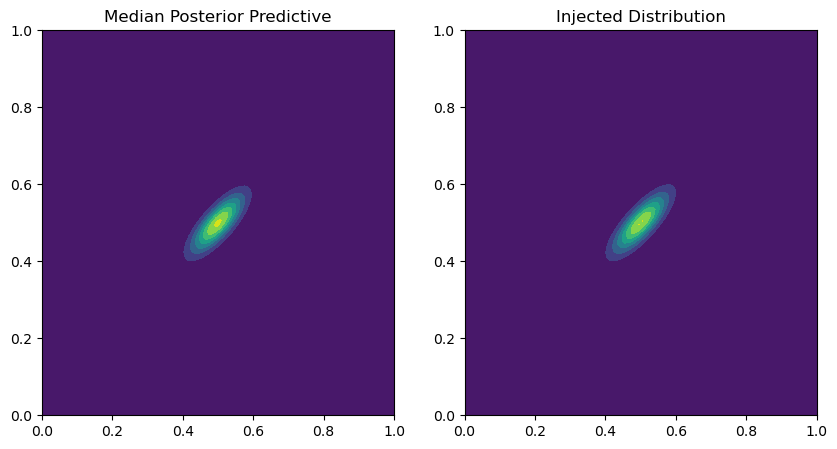

  0%|          | 0/1000 [00:00<?, ?it/s]

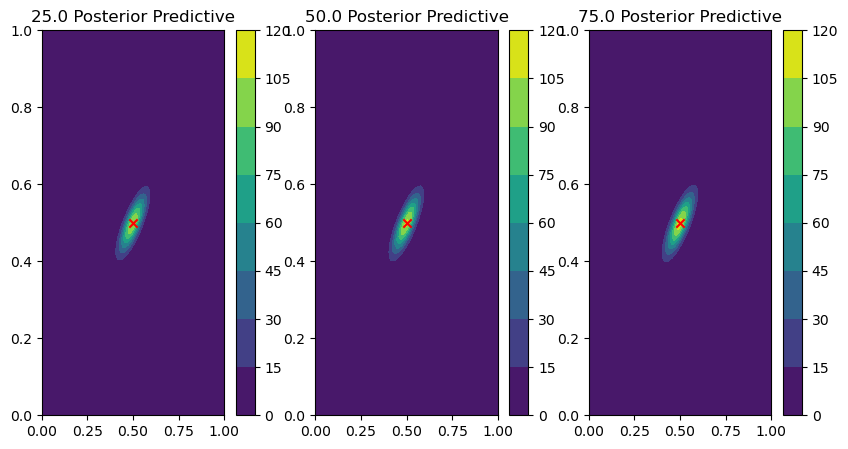

In [158]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.5, 'sigma_x': 0.05, 'mu_y': 0.5, 'sigma_y':0.05, 'rho': 0.8},
                       sigma_likelihood=0.001)


TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)

TGT.plot_intrinsic_parameters();

TGT.infer(TG2D)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

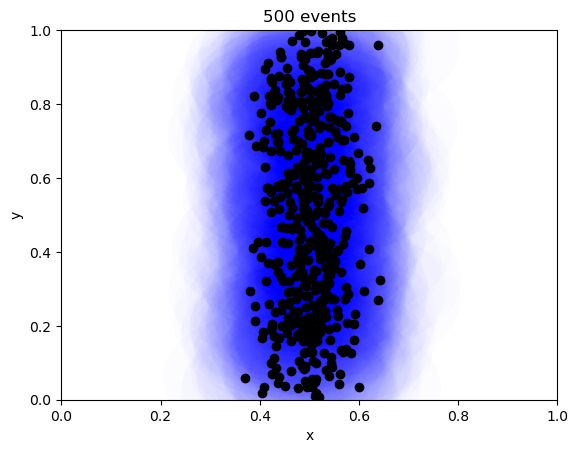

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.69it/s, 63 steps of size 1.11e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.50      0.00      0.50      0.50      0.51    267.35      1.00
      mu_y      0.53      0.11      0.52      0.39      0.63    193.24      1.00
       rho      0.04      0.36      0.03     -0.62      0.59    492.75      1.00
   sigma_x      0.03      0.01      0.03      0.00      0.05    222.08      1.00
   sigma_y      0.64      0.50      0.46      0.30      1.23    107.22      1.01

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


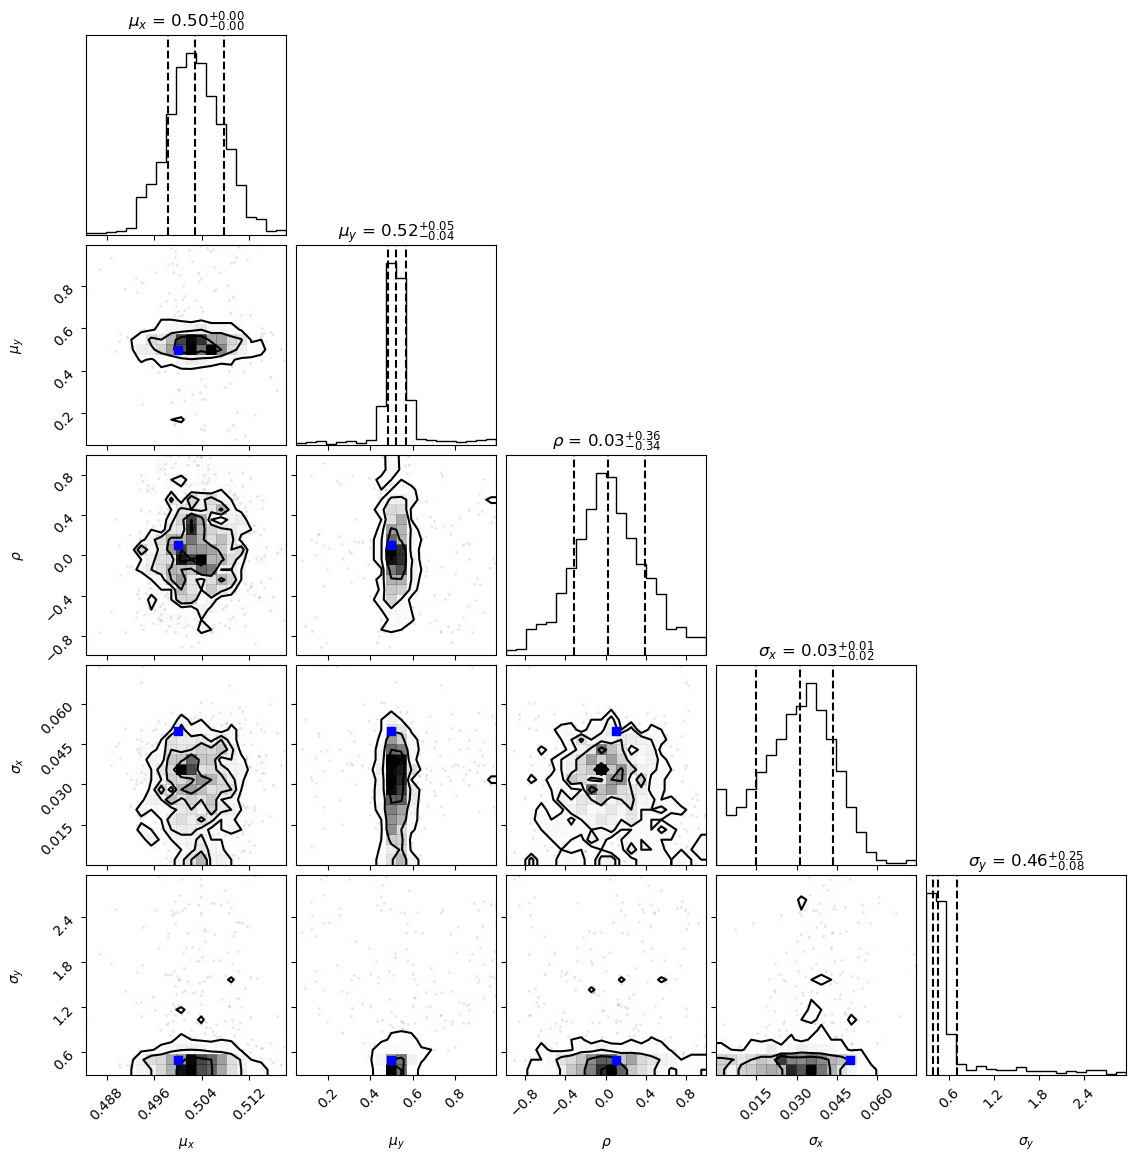

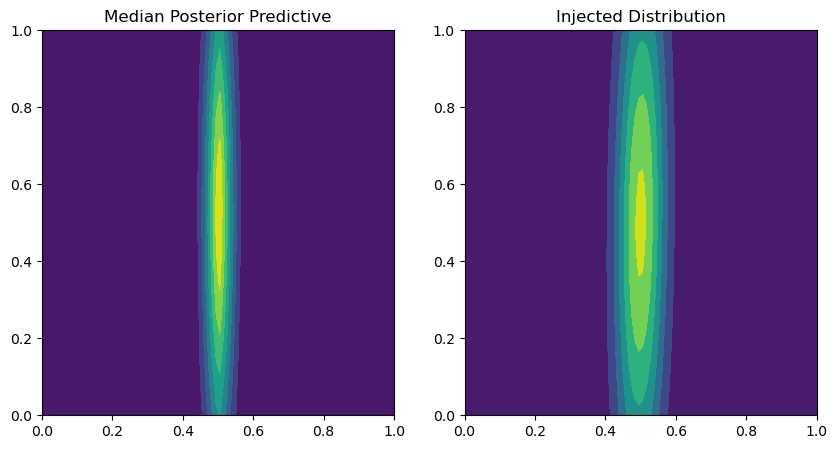

  0%|          | 0/1000 [00:00<?, ?it/s]

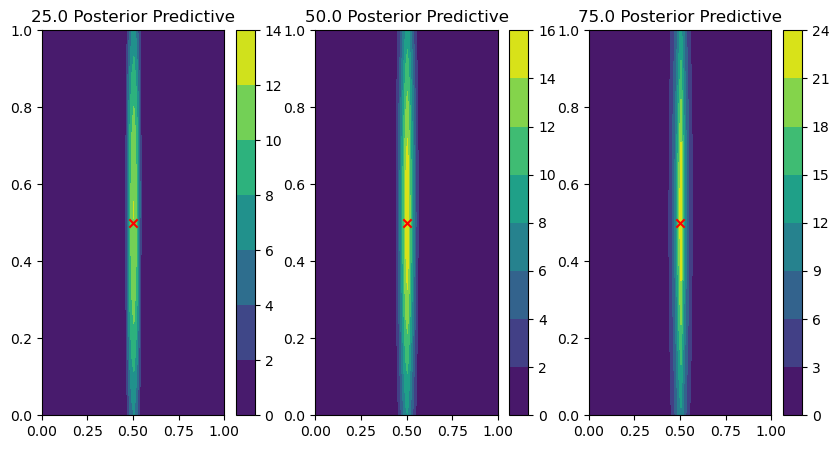

In [169]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.5, 'sigma_x': 0.05, 'mu_y': 0.5, 'sigma_y':0.5, 'rho': 0.1},
                       sigma_likelihood=0.1)


TGT.generate(500)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)

TGT.plot_intrinsic_parameters()

TGT.infer(TG2D)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

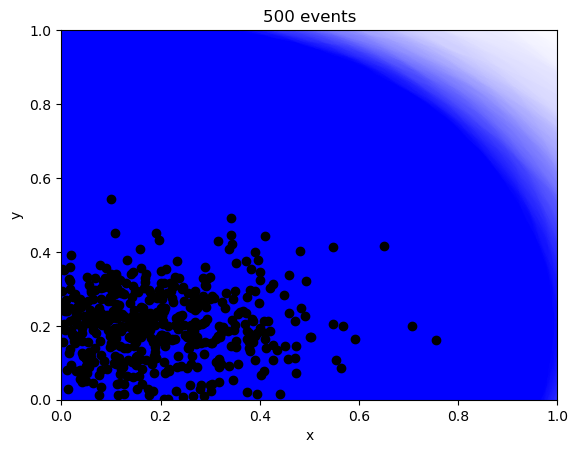

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.04it/s, 31 steps of size 1.65e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.12      0.07      0.12      0.01      0.22    436.63      1.00
      mu_y      0.13      0.07      0.14      0.01      0.22    394.85      1.00
       rho     -0.16      0.51     -0.20     -0.99      0.59    386.29      1.00
   sigma_x      0.19      0.07      0.20      0.08      0.30    416.64      1.01
   sigma_y      0.15      0.08      0.16      0.01      0.25    252.36      1.00

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


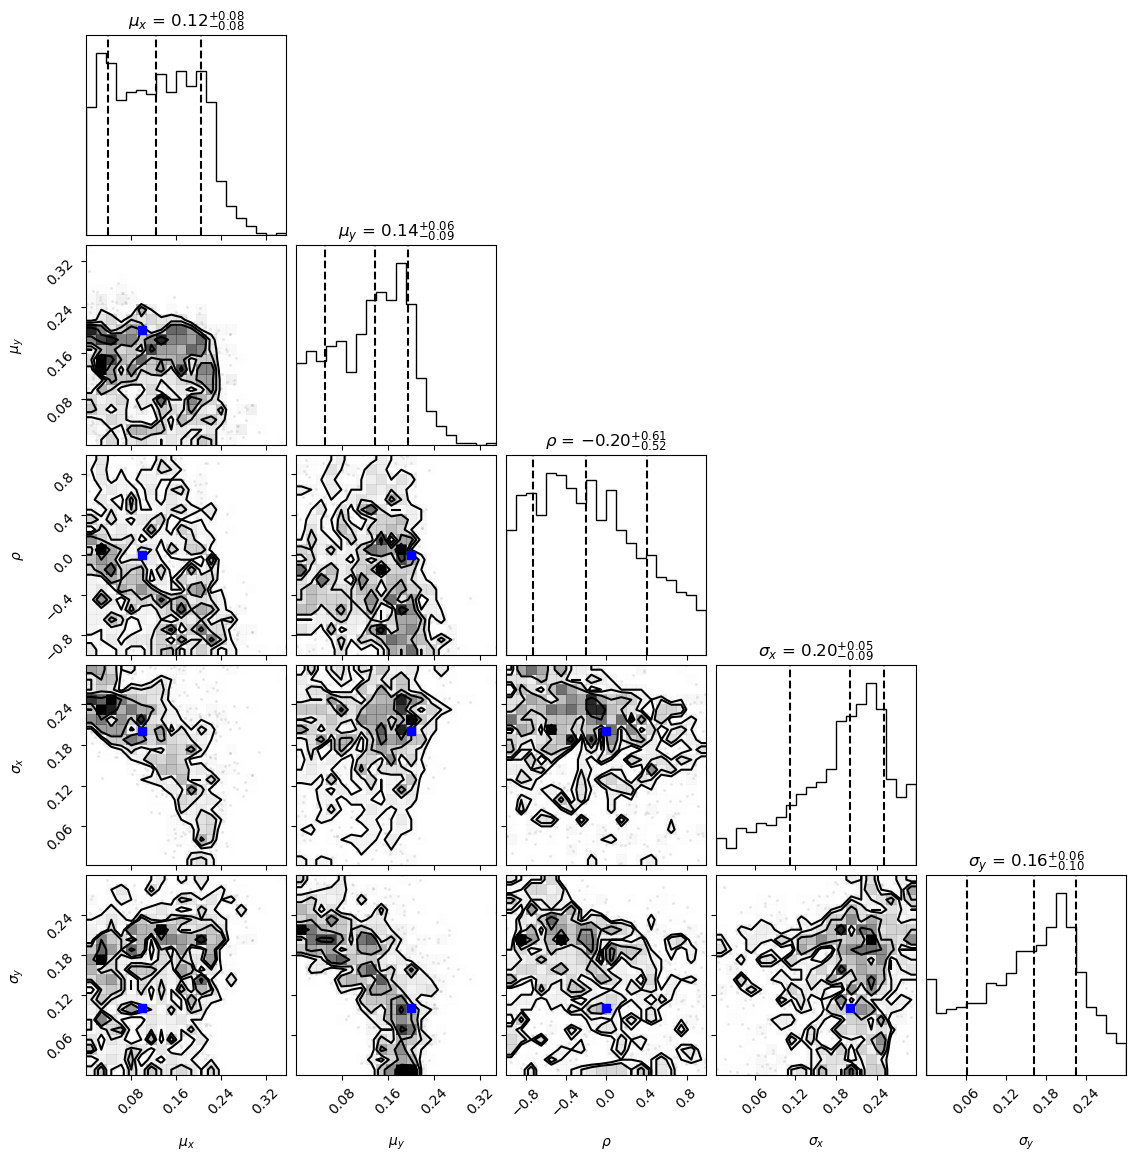

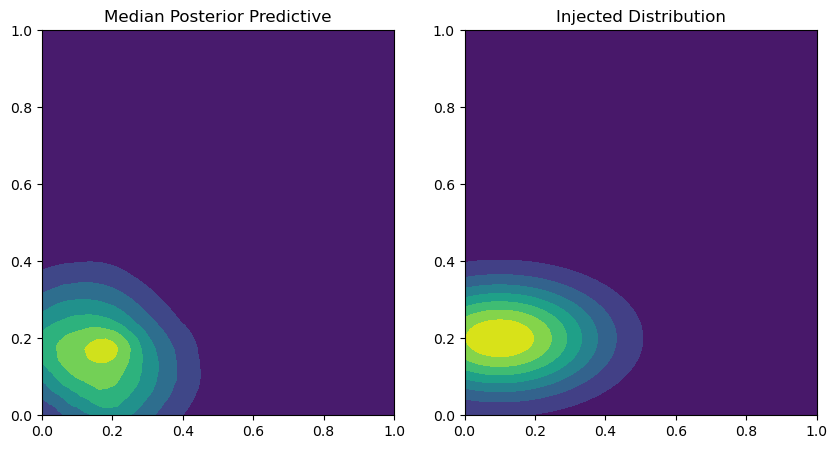

  0%|          | 0/1000 [00:00<?, ?it/s]

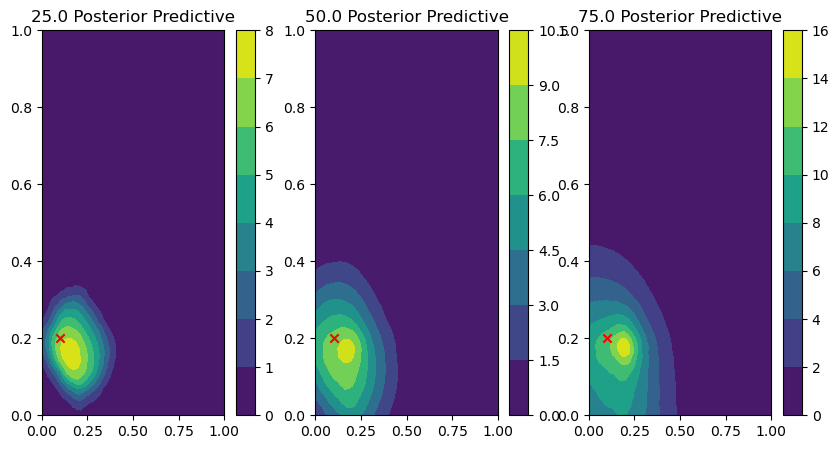

In [170]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.1, 'sigma_x': 0.2, 'mu_y': 0.2, 'sigma_y':0.1, 'rho': 0.0},
                       sigma_likelihood=0.5)


prior_small_sigma = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,0.3), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,0.3), 
    'rho' : dist.Uniform(-1,1)
}

TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D, prior=prior_small_sigma)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

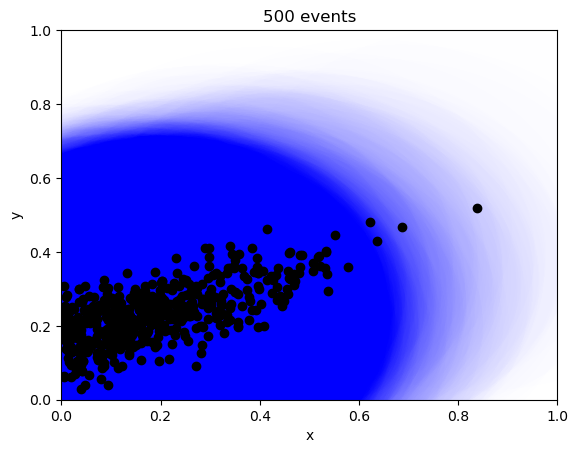

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 41.78it/s, 15 steps of size 2.15e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.15      0.06      0.17      0.06      0.23    231.20      1.00
      mu_y      0.24      0.03      0.24      0.20      0.28    190.07      1.02
       rho      0.11      0.47      0.13     -0.58      0.94    554.98      1.00
   sigma_x      0.14      0.06      0.13      0.04      0.23    374.50      1.00
   sigma_y      0.09      0.05      0.08      0.00      0.15    265.01      1.01

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


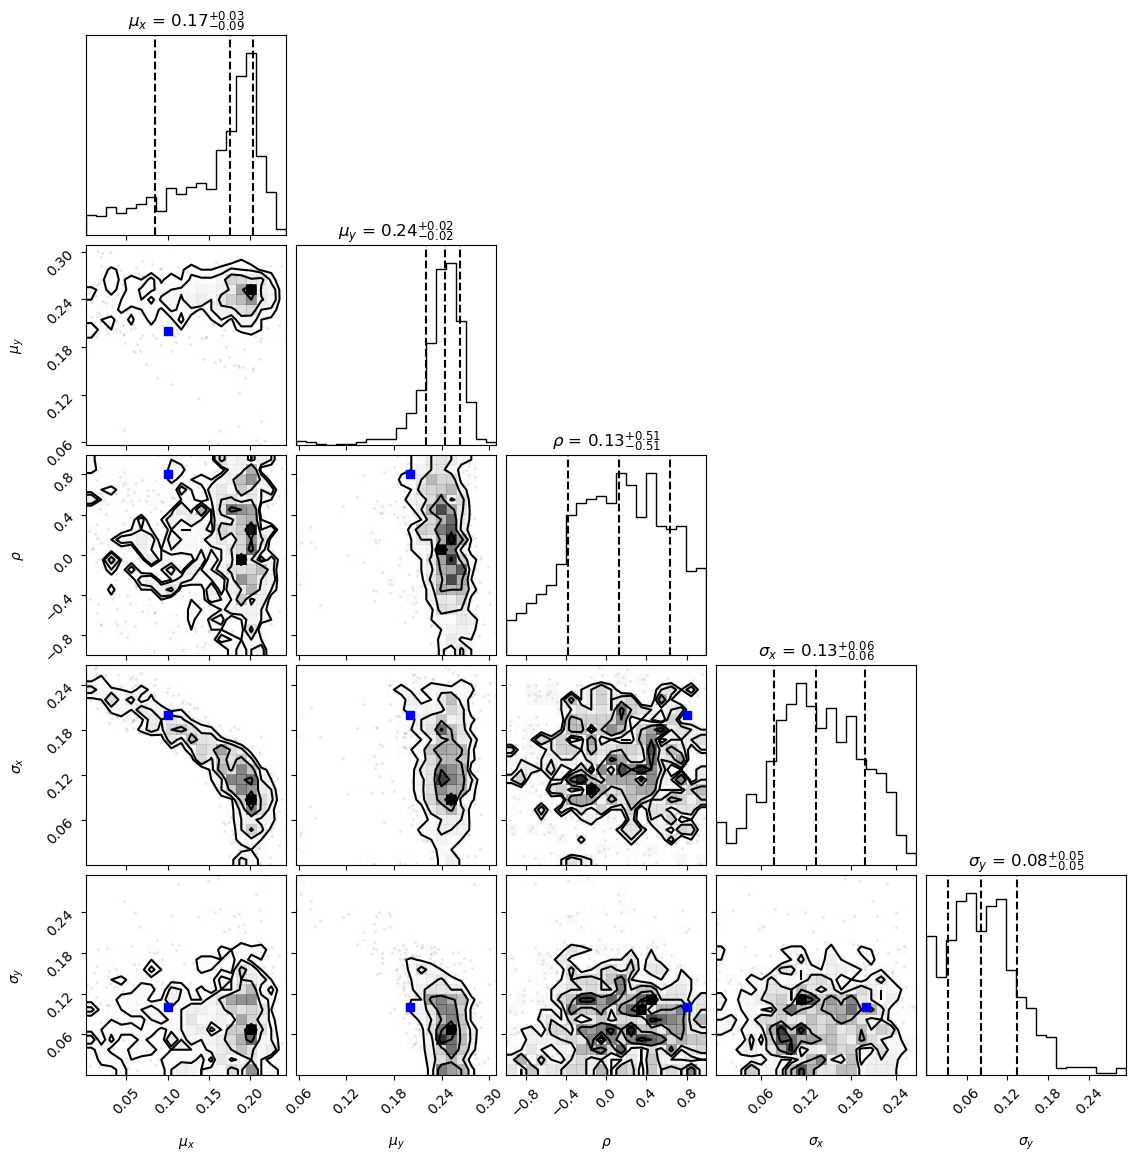

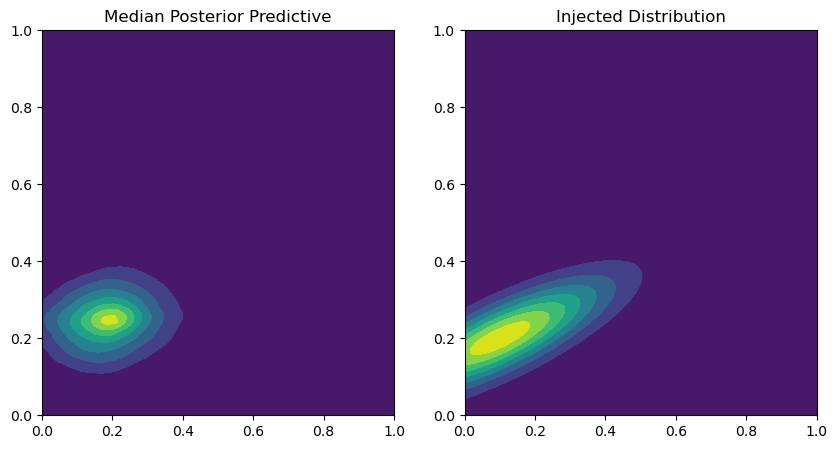

  0%|          | 0/1000 [00:00<?, ?it/s]

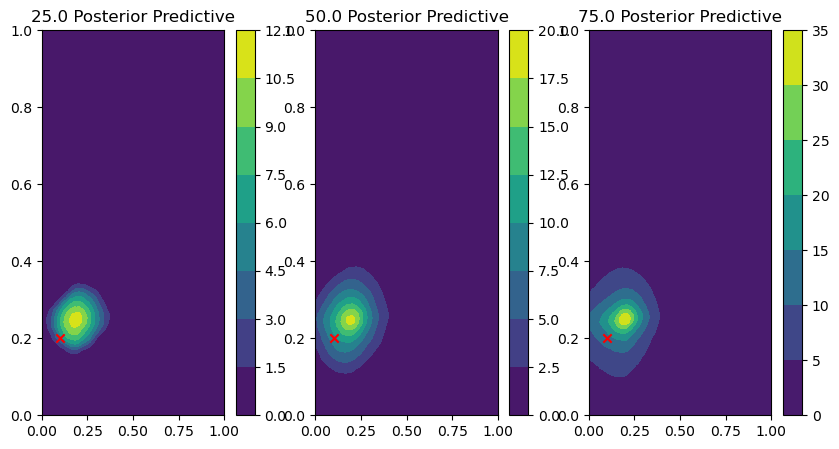

In [171]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.1, 'sigma_x': 0.2, 'mu_y': 0.2, 'sigma_y':0.1, 'rho': 0.8},
                       sigma_likelihood=0.3)


prior_small_sigma = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,0.8), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,0.8), 
    'rho' : dist.Uniform(-1,1)
}

TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D, prior=prior_small_sigma)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

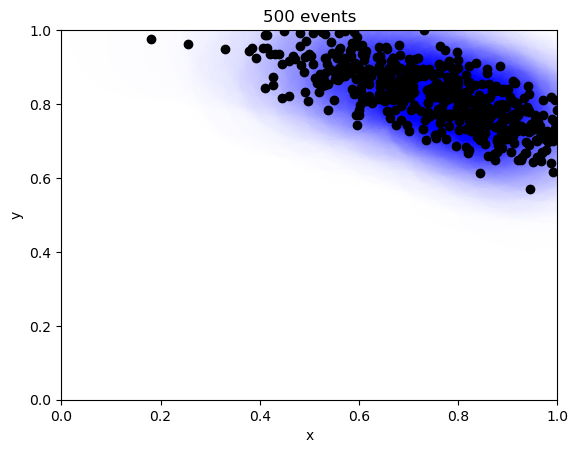

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.55it/s, 15 steps of size 6.03e-02. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.79      0.04      0.79      0.74      0.85     34.44      1.04
      mu_y      0.80      0.02      0.80      0.77      0.83     39.34      1.04
       rho     -0.86      0.05     -0.87     -0.95     -0.78    100.93      1.00
   sigma_x      0.23      0.05      0.22      0.18      0.28     41.59      1.03
   sigma_y      0.12      0.03      0.12      0.09      0.15     68.77      1.02

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


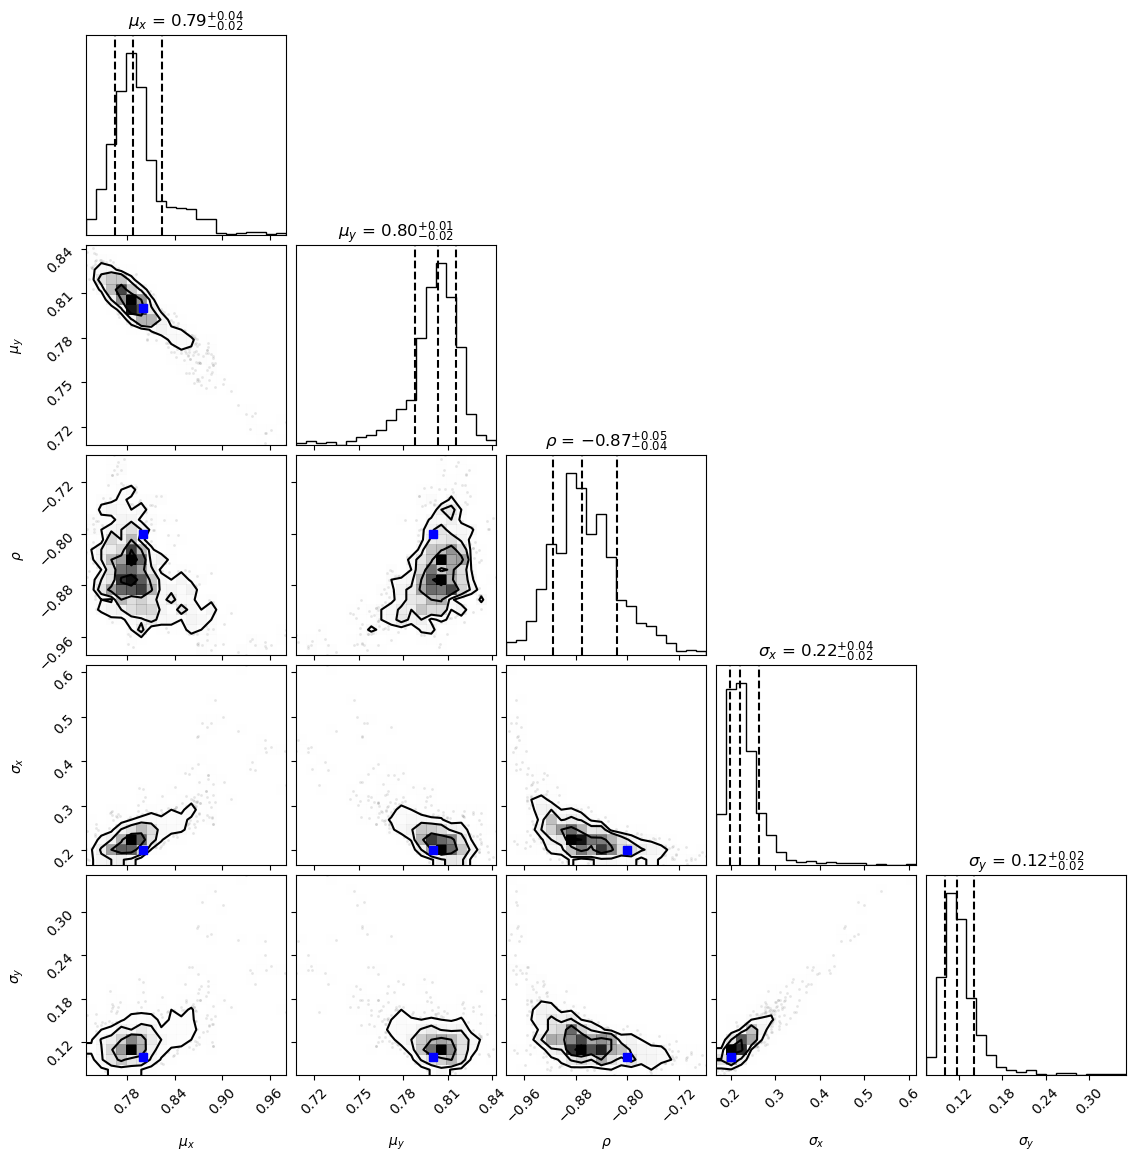

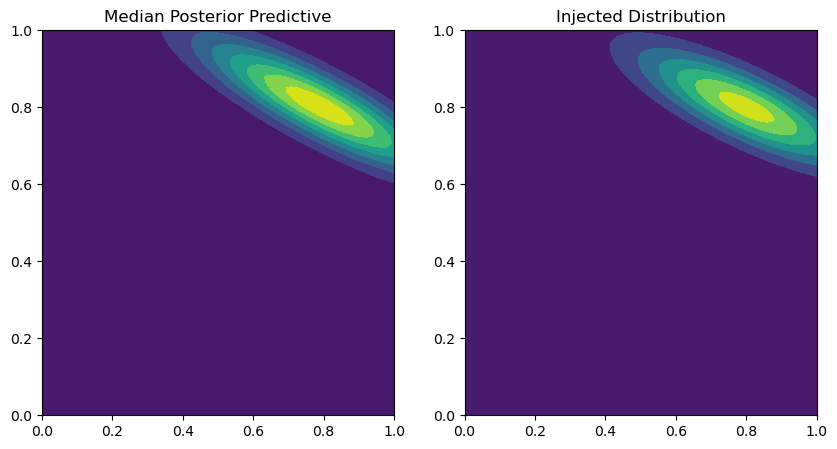

  0%|          | 0/1000 [00:00<?, ?it/s]

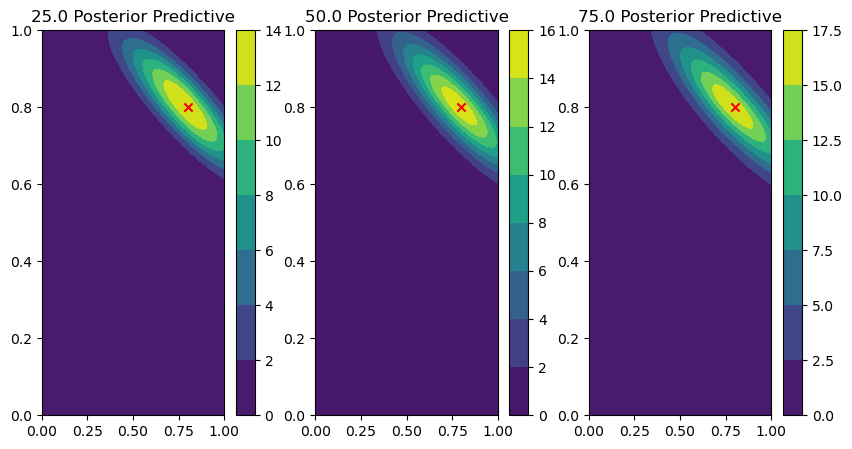

In [172]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.8, 'sigma_x': 0.2, 'mu_y': 0.8, 'sigma_y':0.1, 'rho': -0.8},
                       sigma_likelihood=0.1)


prior_small_sigma = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,0.8), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,0.8), 
    'rho' : dist.Uniform(-1,1)
}

TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D, prior=prior_small_sigma)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

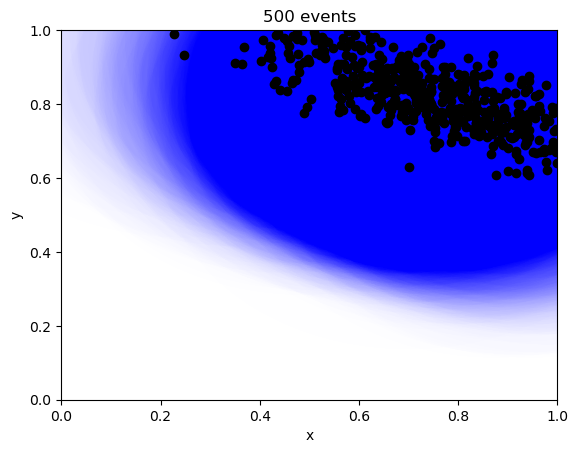

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 25.99it/s, 23 steps of size 8.67e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.78      0.11      0.77      0.61      0.96    329.34      1.00
      mu_y      0.84      0.08      0.83      0.73      0.99    335.49      1.00
       rho     -0.91      0.14     -0.96     -1.00     -0.78    292.03      1.00
   sigma_x      0.43      0.18      0.40      0.17      0.72    213.25      1.00
   sigma_y      0.32      0.14      0.30      0.10      0.56    216.26      1.00

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


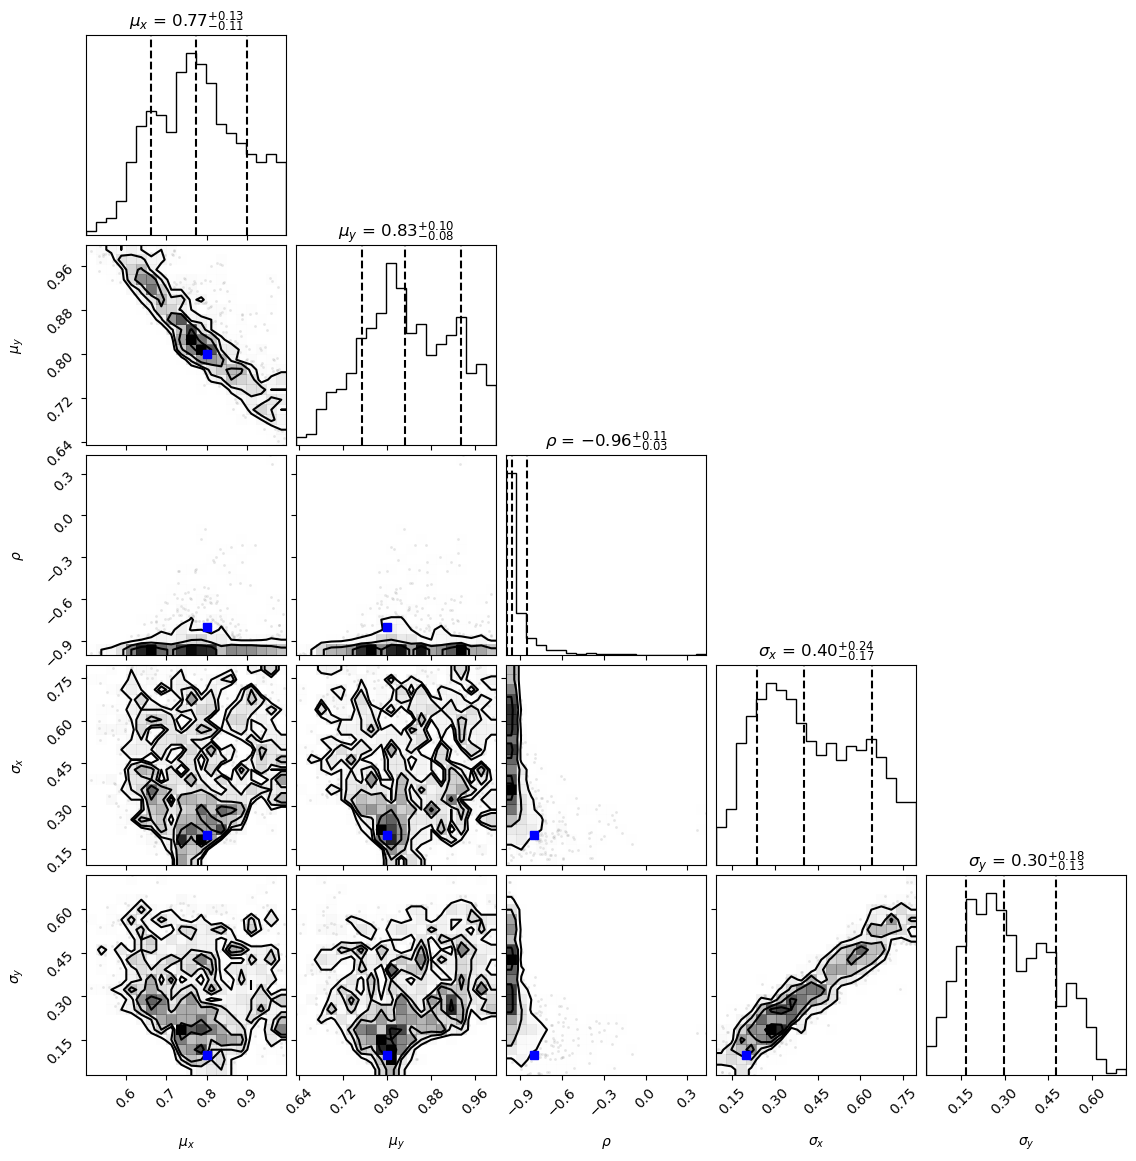

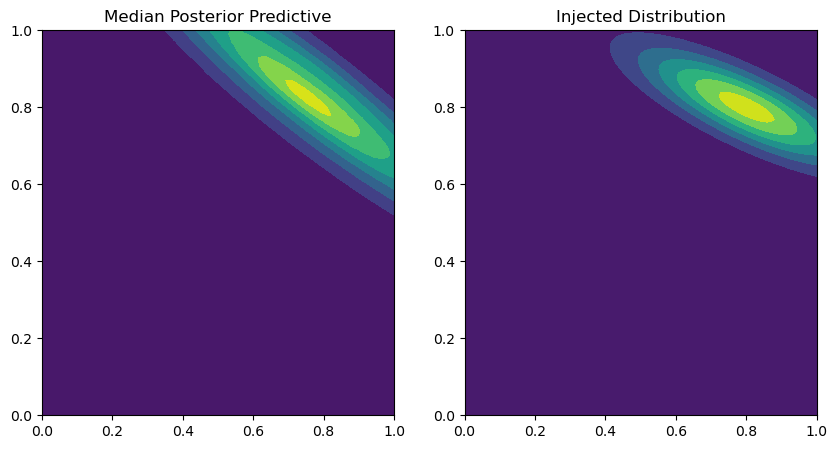

  0%|          | 0/1000 [00:00<?, ?it/s]

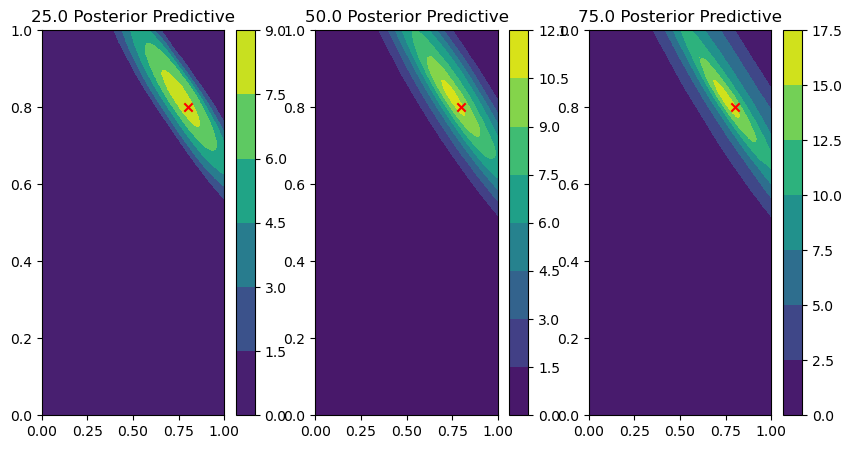

In [173]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.8, 'sigma_x': 0.2, 'mu_y': 0.8, 'sigma_y':0.1, 'rho': -0.8},
                       sigma_likelihood=0.3)


prior_small_sigma = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,0.8), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,0.8), 
    'rho' : dist.Uniform(-1,1)
}

TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D, prior=prior_small_sigma)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

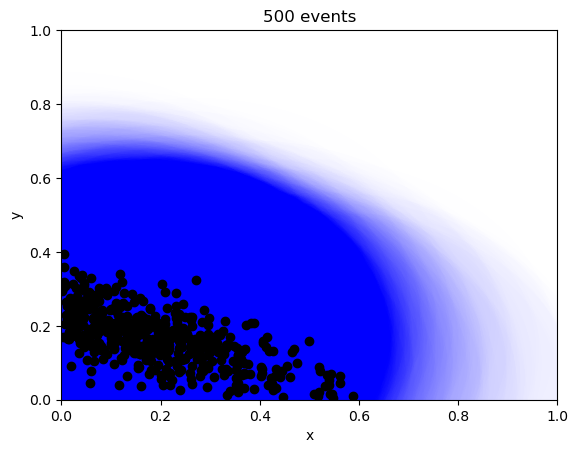

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.38it/s, 15 steps of size 1.25e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.17      0.07      0.18      0.03      0.28    278.52      1.00
      mu_y      0.12      0.07      0.12      0.01      0.20    391.30      1.00
       rho     -0.67      0.36     -0.82     -1.00     -0.10    210.20      1.00
   sigma_x      0.27      0.18      0.22      0.05      0.59    122.54      1.01
   sigma_y      0.25      0.14      0.20      0.08      0.52    126.51      1.01

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


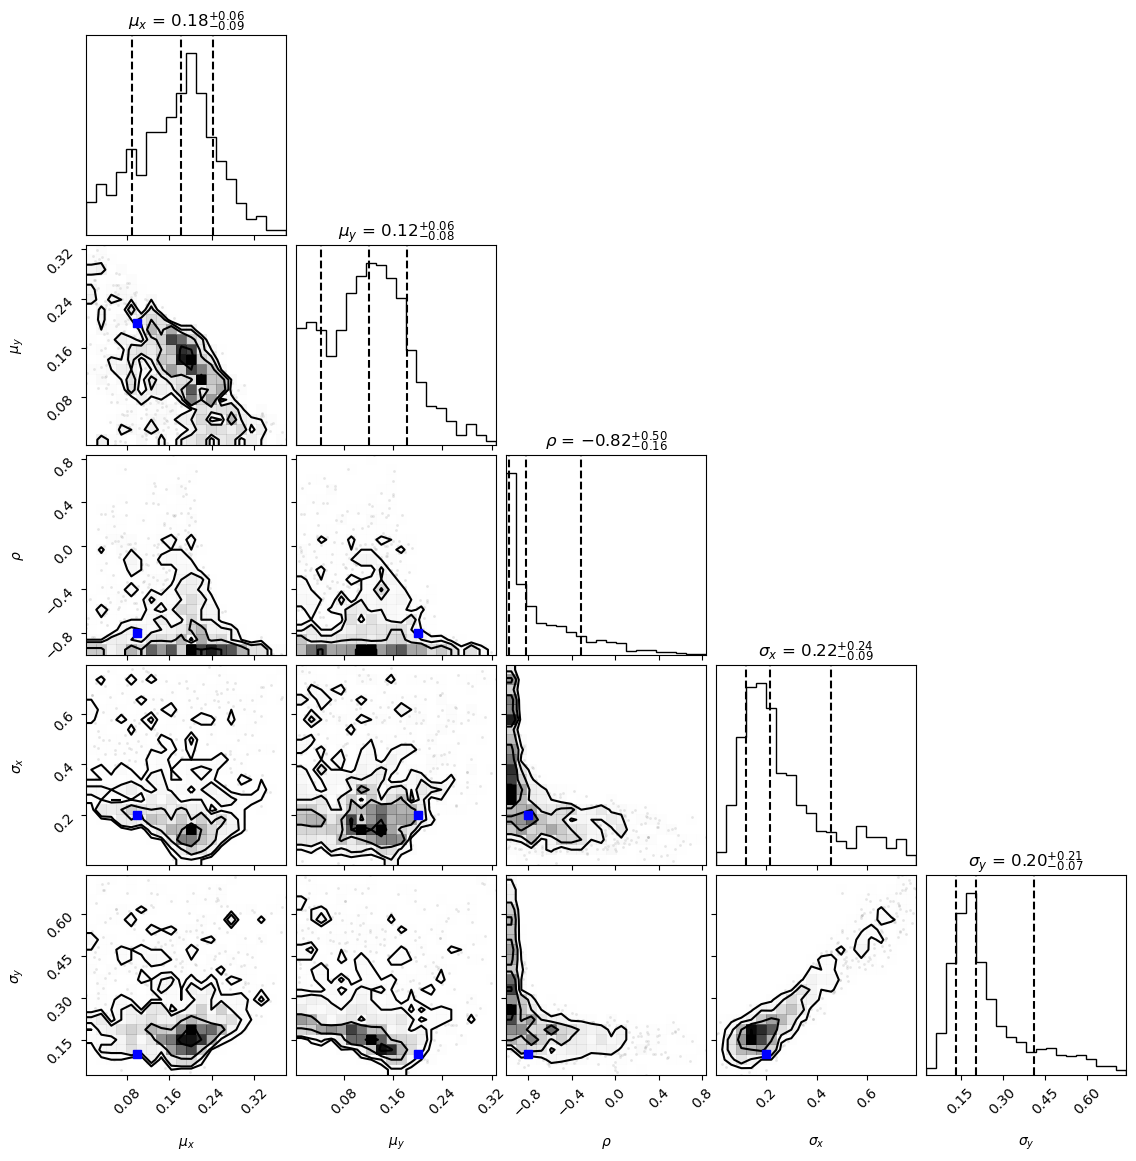

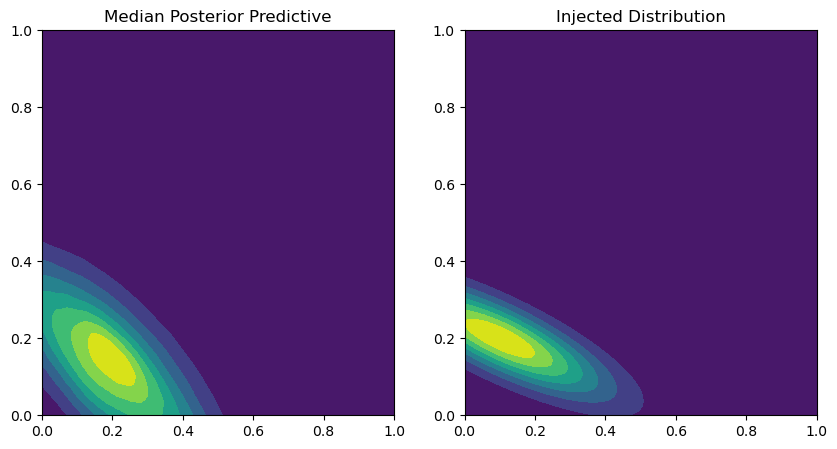

  0%|          | 0/1000 [00:00<?, ?it/s]

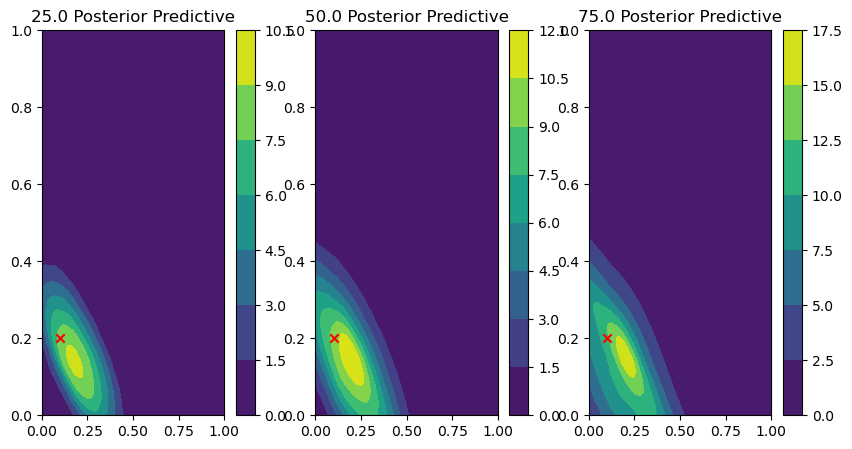

In [174]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.1, 'sigma_x': 0.2, 'mu_y': 0.2, 'sigma_y':0.1, 'rho': -0.8},
                       sigma_likelihood=0.3)


prior_small_sigma = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,0.8), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,0.8), 
    'rho' : dist.Uniform(-1,1)
}

TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D, prior=prior_small_sigma)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()

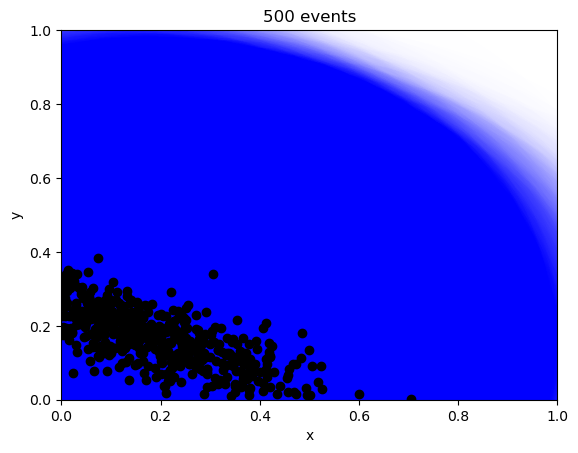

No selection function provided


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:54<00:00, 36.60it/s, 15 steps of size 1.49e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.15      0.07      0.16      0.03      0.24    488.43      1.00
      mu_y      0.16      0.06      0.18      0.04      0.24    322.71      1.01
       rho     -0.04      0.58     -0.03     -1.00      0.76    437.08      1.00
   sigma_x      0.17      0.12      0.16      0.00      0.27    284.51      1.01
   sigma_y      0.13      0.12      0.10      0.00      0.25    256.85      1.00

Number of divergences: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/4g/bjm_kb714yl_6tgcqd4jbmqh0000gn/T/ipykernel_83683/2226853849.py:137: UserWarning: The following kwargs were not used by contour: 'axis'
  axes[1].contourf(data_grid['x'], data_grid['y'], Z_init,axis=0)


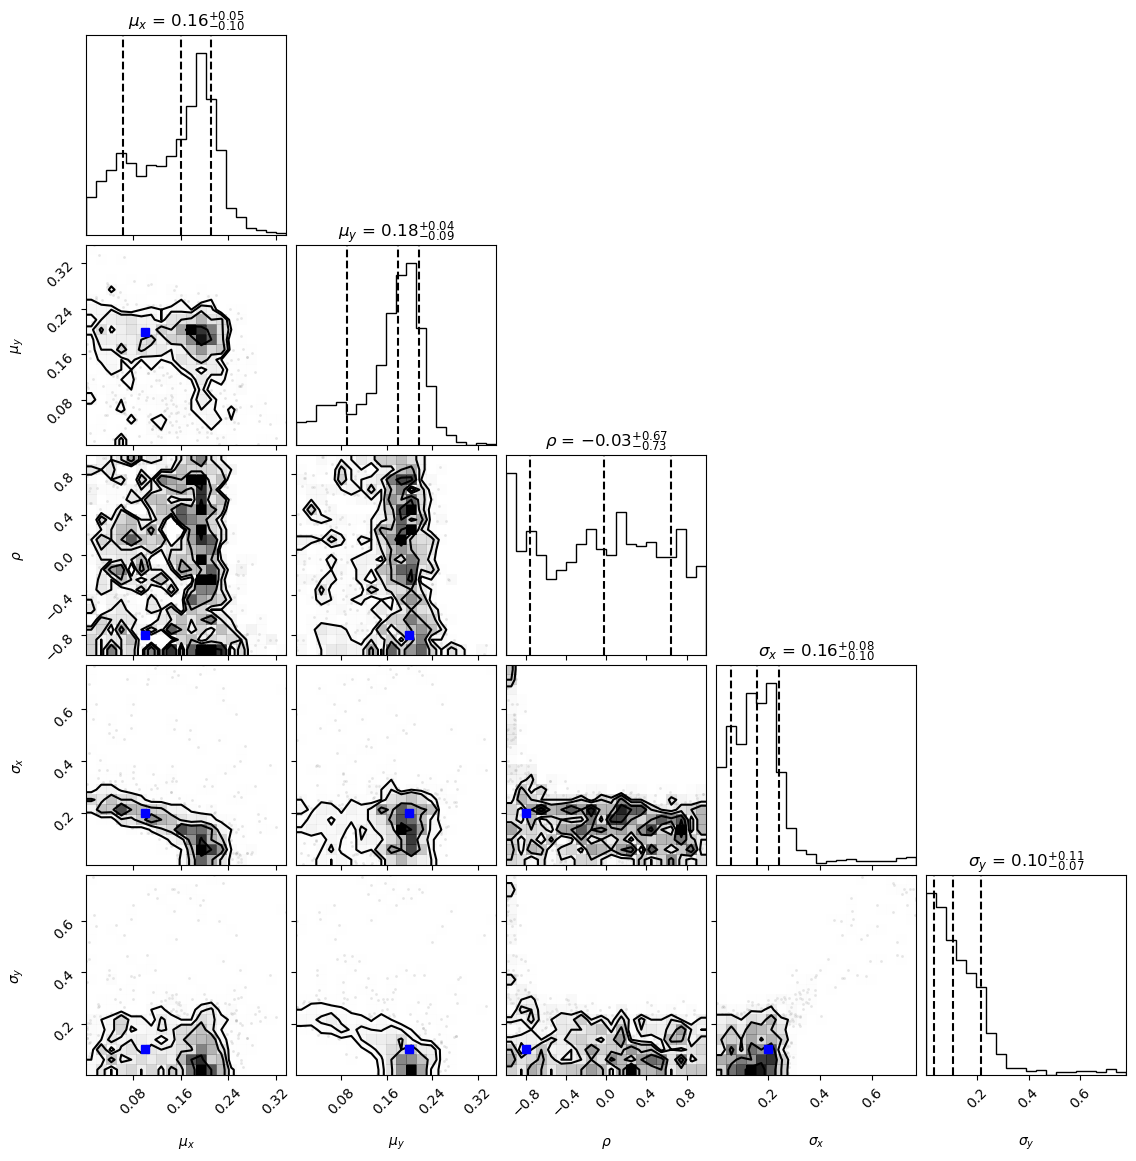

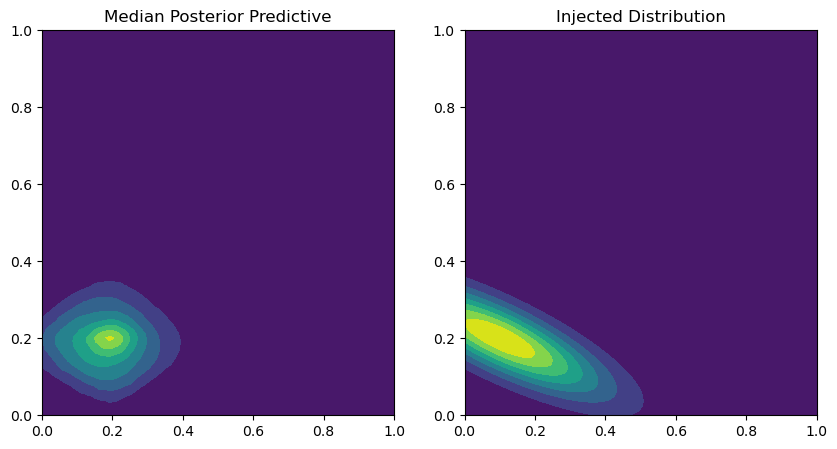

  0%|          | 0/1000 [00:00<?, ?it/s]

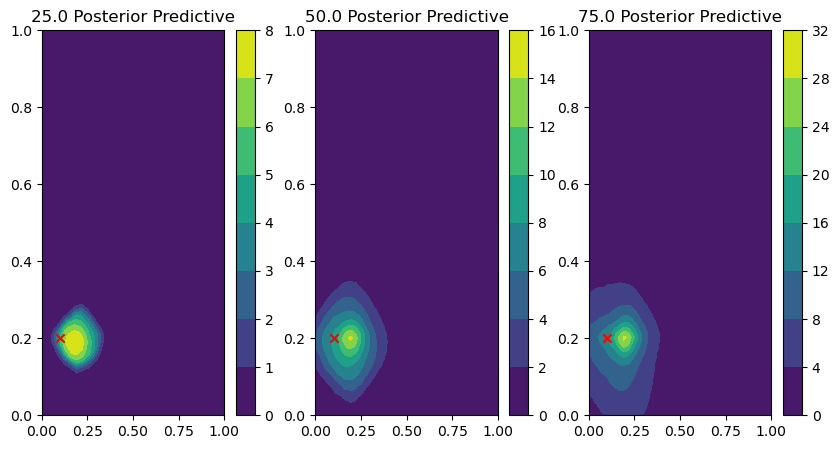

In [175]:
TGT = TruncatedGaussianTests(parameters = {'mu_x' : 0.1, 'sigma_x': 0.2, 'mu_y': 0.2, 'sigma_y':0.1, 'rho': -0.8},
                       sigma_likelihood=0.5)


prior_small_sigma = {
    'mu_x' : dist.Uniform(0,1), 
    'sigma_x' : dist.Uniform(0,0.8), 
    'mu_y' : dist.Uniform(0,1), 
    'sigma_y': dist.Uniform(0,0.8), 
    'rho' : dist.Uniform(-1,1)
}

TGT.generate(100)
TGT.create_data();


var_names = ['x', 'y']
hyper_var_names = ['mu_x', 'sigma_x', 'mu_y', 'sigma_y', 'rho']
a = [0.0, 0.0]
b = [1.0, 1.0]

TG2D = TruncatedGaussian2DAnalytic(a=a, b=b, var_names=var_names, hyper_var_names=hyper_var_names)


TGT.plot_intrinsic_parameters(alpha=0.00199);

TGT.infer(TG2D, prior=prior_small_sigma)

TGT.compare_posterior_predictive()

TGT.quantile_posterior_predictive()